<a href="https://www.kaggle.com/code/joeroberts/model-one-hot-bidir-lstm?scriptVersionId=112866344" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from transformers import BertTokenizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#configs
max_tokens = 20000
max_length = 600
developing = False

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [4]:
sample_submission_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
train_data_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_from_comp = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

In [5]:
train, test = train_test_split(train_data_raw, test_size=0.2, random_state=21) #20% for test
train, val = train_test_split(train, test_size=0.1, random_state=21) # 10% for validation
train

targets=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

train_targets = train[targets]
val_targets = val[targets]
test_targets = test[targets]

train_targets_ds = tf.convert_to_tensor(train_targets)
val_targets_ds = tf.convert_to_tensor(val_targets)
test_targets_ds = tf.convert_to_tensor(test_targets)

train_text_only = tf.convert_to_tensor(train['full_text'])
val_text_only = tf.convert_to_tensor(val['full_text'])
test_text_only = tf.convert_to_tensor(test['full_text'])

## for submission 
all_train_targets = train_data_raw[targets]
all_train_targets_ds = tf.convert_to_tensor(all_train_targets)
all_train_text_only = tf.convert_to_tensor(train_data_raw['full_text'])

all_test_text_only = tf.convert_to_tensor(test_from_comp['full_text'])


2022-12-03 21:43:03.623080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 21:43:03.710677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 21:43:03.711497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 21:43:03.713685: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
# text_vectorization = layers.TextVectorization(
#     max_tokens=max_tokens,
#     output_mode="multi_hot"
# )

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

#use the dataset to index the dataset vocab via the adapt method
text_vectorization.adapt(train_text_only)

train_features_ds = text_vectorization(train_text_only)
val_features_ds = text_vectorization(val_text_only)
test_features_ds = text_vectorization(test_text_only)

#for submission
all_train_features_ds = text_vectorization(all_train_text_only)
all_test_features_ds = text_vectorization(all_test_text_only)


2022-12-03 21:43:12.095615: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:
def get_model(max_tokens=max_tokens, hidden_dim=32):
    
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = tf.one_hot(inputs, depth=max_tokens)
    
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(embedded)
    x = layers.Dropout(rate=0.5)(x)

    outputs = layers.Dense(6, activation=None)(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="mean_absolute_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError(
                name='root_mean_squared_error', dtype=None
            )]
    )
    return model


#train model and test
model = get_model()
model.summary()

if developing:

    callbacks = [
        keras.callbacks.ModelCheckpoint("model_one_hot_bidir_lstm.keras", save_best_only=True)
    ]
    hist = model.fit(
        x=train_features_ds,
        y=train_targets_ds,
        validation_data = (
            val_features_ds, val_targets_ds
        ),
        epochs=25,
        callbacks=callbacks
    )

    model = keras.models.load_model("model_one_hot_bidir_lstm.keras")
    print(f"Test acc: {model.evaluate(test_features_ds, test_targets_ds, 1)}")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
tf.one_hot (TFOpLambda)      (None, None, 20000)       0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                5128448   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 5,128,838
Trainable params: 5,128,838
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25


2022-12-03 21:43:29.320786: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


88/88 [==============================] - 26s 241ms/step - loss: 1.4051 - root_mean_squared_error: 1.7938 - val_loss: 0.5530 - val_root_mean_squared_error: 0.6942
Epoch 2/25
88/88 [==============================] - 21s 235ms/step - loss: 0.7307 - root_mean_squared_error: 0.9167 - val_loss: 0.5508 - val_root_mean_squared_error: 0.6854
Epoch 3/25
88/88 [==============================] - 21s 235ms/step - loss: 0.6810 - root_mean_squared_error: 0.8564 - val_loss: 0.5530 - val_root_mean_squared_error: 0.6910
Epoch 4/25
88/88 [==============================] - 21s 235ms/step - loss: 0.6545 - root_mean_squared_error: 0.8179 - val_loss: 0.5397 - val_root_mean_squared_error: 0.6739
Epoch 5/25
88/88 [==============================] - 21s 236ms/step - loss: 0.6174 - root_mean_squared_error: 0.7762 - val_loss: 0.5430 - val_root_mean_squared_error: 0.6671
Epoch 6/25
88/88 [==============================] - 21s 235ms/step - loss: 0.5986 - root_mean_squared_error: 0.7548 - val_loss: 0.5222 - val_root_

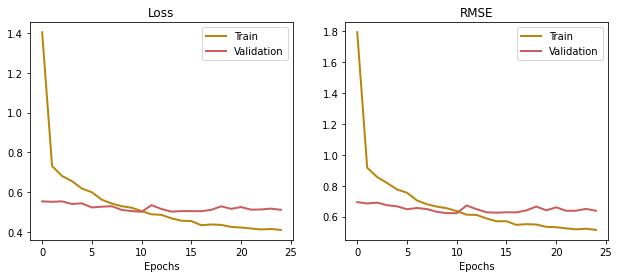

In [8]:
if developing:
    # grab history
    history = hist.history

    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)

    plt.plot(history['loss'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_loss'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('Loss');

    ax = fig.add_subplot(1, 3, 2)

    plt.plot(history['root_mean_squared_error'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_root_mean_squared_error'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('RMSE');


In [9]:
#
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("counts_2gram.keras", save_best_only=True)
]
hist = model.fit(
    x=all_train_features_ds,
    y=all_train_targets_ds,
    validation_data = None,
    epochs=10,
    callbacks=callbacks
)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
tf.one_hot_1 (TFOpLambda)    (None, None, 20000)       0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                5128448   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 5,128,838
Trainable params: 5,128,838
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
123/123 [==============================] - 29s 218ms/step - loss: 1.2781 - root_mean_squared_error: 1.65

## Submission to contest

In [ ]:
test_predictions = model.predict(all_test_features_ds)
test_predictions = pd.DataFrame(test_predictions)

test_from_comp['cohesion'] = test_predictions[0]
test_from_comp['syntax'] = test_predictions[1]
test_from_comp['vocabulary'] = test_predictions[2]
test_from_comp['phraseology'] = test_predictions[3]
test_from_comp['grammar'] = test_predictions[4]
test_from_comp['conventions'] = test_predictions[5]
test_from_comp

In [ ]:
res = test_from_comp.drop("full_text",axis=1)
res.to_csv("/kaggle/working/submission.csv",index=False)